In [1]:
import random
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import numpy as np
pd.options.display.max_colwidth = 1000
pd.options.mode.chained_assignment = None


##### Load Data

In [2]:
df = pd.read_excel('../data_processed/taliban_tweets.xlsx')

##### Drop Null, Empty, and NaN values

In [3]:
df.dropna(subset=['text'], inplace=True) #remove nan value
df.drop_duplicates(subset=['text'], inplace=True) #remove nan duplicate value
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=1, how='all').loc[:, df.notna().any()]

##### Clean Data

In [4]:
df['text'] = df['text'].str.replace('&amp;', ' ')

In [5]:
def clean_tweet_text(text):
    # Check for null or NaN values
    if pd.isnull(text):
        return text
    # Remove URL
    text = re.sub(r'http\S+', '', text)
    
    # Remove RT (retweet) tag
    text = text.replace('RT', '')
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters and punctuations, and add a space after removing them
    text = re.sub(r'[^\w\s]', '', text)

    # Remove hashtags
    text = re.sub(r'#(\w+)', '', str(text))
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Convert to lowercase
    text = text.lower()
    
    return text
# Apply the cleaning function to 'text' column
df['text'] = df['text'].apply(clean_tweet_text)


In [6]:
# df = pd.read_excel('../data_processed/taliban_tweets.xlsx')

##### Remove Text Less then 30 characters

In [7]:
df = df[df['text'].str.len() >=30]

##### Remove Empty Rows

In [8]:
def remove_empty_rows(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Remove rows with empty values in the column
        df = df[df[column].notna() & df[column].astype(str).str.strip().ne('')]
    return df

df = remove_empty_rows(df)


##### Remove All Null Values

In [9]:
def remove_null_columns(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Check if the column contains any null values
        if df[column].isnull().any():
            # If any null value exists, drop the column
            df = df.drop(column, axis=1)
    return df
df = remove_null_columns(df)


##### Remove Stopwords

In [10]:
from nltk.corpus import stopwords
def remove_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    return df
df = remove_stopwords(df)

##### Convert Timezone

In [11]:
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date.astype(str)

##### Drop the whole rows which is >=2020

In [12]:
df["created_at"] = pd.to_datetime(df["created_at"], format="%Y-%m-%d")
filtered_df = df[df["created_at"].dt.year >= 2020]
df.drop(df[df["created_at"].dt.year <= 2020].index, inplace=True)


##### Check How Many accounts are there

In [13]:
len(df['name'].unique())

53

##### Labeling Process

In [14]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].astype(str)

In [15]:
def label_tweets(text):
    keywords = ['education', 'school', 'university', 'women', 'girl']
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0
df = df.copy()
df['label'] = df['text'].apply(label_tweets)

##### Sentiment Analysis

In [16]:
x = df['text']
sentiment_labels = []
sentiment_scores = []
for tweet in x:
    # Create a TextBlob object
    blob = TextBlob(tweet)
    # Get the sentiment polarity (-1 to 1)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    sentiment_labels.append(sentiment)
    sentiment_scores.append(polarity)
# Add the sentiment labels and scores as new columns in the DataFrame
df['sentiment'] = sentiment_labels
df['sentiment_score'] = sentiment_scores

##### Data Set Summary

In [17]:
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment Counts:\n", sentiment_counts)
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Total Counts:", total_counts)

Sentiment Counts:
 sentiment
positive    34009
neutral     25757
negative    16204
Name: count, dtype: int64
Total Counts: 50213


In [18]:
df.shape

(75970, 9)

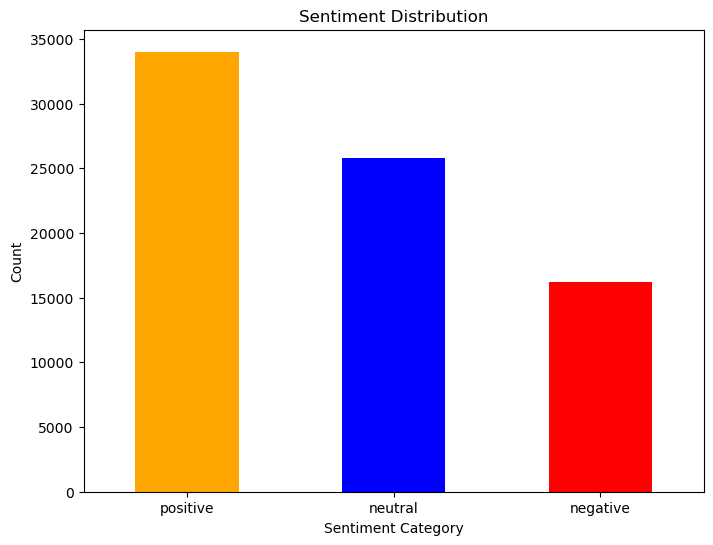

Sentiment Distribution: 50213


In [19]:
# Define custom colors for sentiment categories
colors = {'negative': 'red', 'neutral': 'blue', 'positive': 'orange'}

# Calculate sentiment counts
sentiment_counts = df['sentiment'].value_counts()

# Plot the sentiment counts with custom colors
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=[colors.get(x, 'gray') for x in sentiment_counts.index])
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.title('Sentiment Distribution')
plt.show()

# Calculate total counts
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Sentiment Distribution:", total_counts)


##### Calculate positive tweets and percentage for taliban, single user

In [20]:
women_positive_count = df[(df['gender'] == 'male') & (df['sentiment'] == 'positive')].shape[0]
women_total_count = df[df['gender'] == 'male'].shape[0]
women_positive_percentage = (women_positive_count / women_total_count) * 100
# Print the results
print("Positive tweets from taliban:", women_positive_count, "(", women_positive_percentage, "%)")

Positive tweets from taliban: 34009 ( 44.76635514018692 %)


##### Content Analysis

In [21]:
df_edu = df.loc[df['label'] == 1]
print("Number of tweets in favor of education: ", len(df_edu))

Number of tweets in favor of education:  3757


##### Code Schema

In [22]:
coding_scheme = {
'women': ['women', 'woman', 'female', 'feminine', 'girl', 'lady'],
'education': ['education', 'educational', 'learning', 'academics', 'knowledge'],
'school': ['school', 'classroom', 'teacher', 'students', 'curriculum'],
'university': ['university', 'college', 'higher education', 'academia', 'campus'],
'access': ['access', 'opportunity', 'enrollment', 'attendance', 'entry'],
'quality': ['quality', 'standard', 'curriculum', 'teaching', 'learning'],
'benefits': ['benefit', 'advantage', 'improvement', 'progress'],
'barriers': ['barrier', 'restriction', 'obstacle', 'challenge', 'difficulty'],
'empowerment': ['empower', 'empowering', 'confidence', 'self-esteem', 'agency'],
'gender': ['gender', 'discriminatioan', 'inequality', 'feminism', 'patriarchy']
}

# Define a function to apply the coding scheme to each tweet
def apply_coding_scheme(text):
    codes = []
    for code, keywords in coding_scheme.items():
        for keyword in keywords:
            if keyword in text.lower():
                codes.append(code)
    return codes

# Apply the coding scheme to the text column and create a new column for the codes
df_edu['codes'] = df_edu['text'].apply(apply_coding_scheme)

In [23]:
print(df_edu[['codes']].head())

                       codes
1     [education, education]
31       [education, school]
44  [education, empowerment]
51            [women, women]
55                   [women]


In [24]:
# Define the coding scheme
coding_scheme = {
    'women': ['women', 'woman', 'female', 'feminine', 'girl', 'lady'],
    'education': ['education', 'educational', 'learning', 'academics', 'knowledge'],
    'school': ['school', 'classroom', 'teacher', 'students', 'curriculum'],
    'university': ['university', 'college', 'higher education', 'academia', 'campus'],
    'access': ['access', 'opportunity', 'enrollment', 'attendance', 'entry'],
    'quality': ['quality', 'standard', 'curriculum', 'teaching', 'learning'],
    'benefits': ['benefit', 'advantage', 'improvement', 'progress'],
    'barriers': ['barrier', 'restriction', 'obstacle', 'challenge', 'difficulty'],
    'empowerment': ['empower', 'empowering', 'confidence', 'self-esteem', 'agency'],
    'gender': ['gender', 'discrimination', 'inequality', 'feminism', 'patriarchy']
}

# Function to apply the coding scheme to each text
def apply_coding_scheme(text):
    codes = []
    for code, keywords in coding_scheme.items():
        for keyword in keywords:
            if keyword in text.lower():
                codes.append(code)
                break  # Exit the inner loop after finding a match for the current code
    return codes

# Apply the coding scheme to the 'text' column and create a new column 'codes'
df['codes_1'] = df['text'].apply(apply_coding_scheme)


In [25]:
# df_edu[['text','sentiment','sentiment_score','gender','label','codes']].sample(5)

##### Visualization

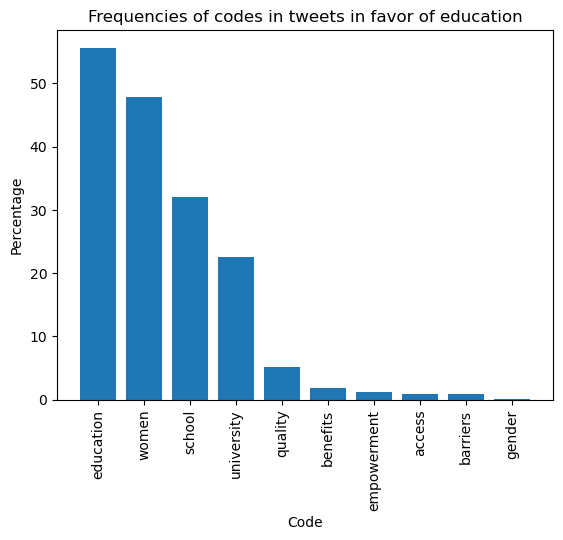

In [26]:
df_codes = df_edu.explode('codes')
# Calculate the frequency and percentage of each code
code_freq = df_codes['codes'].value_counts()
code_perc = code_freq / len(df_edu) * 100
# Plot the code frequencies as a bar chart
plt.bar(code_perc.index, code_perc.values)
plt.title('Frequencies of codes in tweets in favor of education')
plt.xlabel('Code')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.show()

In [27]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()
# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())


Sentiment analysis of tweets containing the keyword 'women':
sentiment
negative    278
neutral     341
positive    533
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'education':
sentiment
negative     224
neutral      258
positive    1205
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'school':
sentiment
negative    172
neutral     166
positive    340
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'university':
sentiment
negative     75
neutral     156
positive    248
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'girl':
sentiment
negative    118
neutral     124
positive    223
Name: text, dtype: int64


In [28]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets['sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    
    # Calculate the sentiment distribution for the keyword
    sentiment_distribution = keyword_tweets.groupby('sentiment')['text'].count()
    total_tweets = sentiment_distribution.sum()
    
    # Calculate the percentage of each sentiment category
    sentiment_percentage = sentiment_distribution / total_tweets * 100
    
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    for sentiment, count in sentiment_distribution.items():
        percentage = sentiment_percentage[sentiment]
        if sentiment == 'positive':
            sentiment_label = 'Positive'
        elif sentiment == 'negative':
            sentiment_label = 'Negative'
        else:
            sentiment_label = 'Neutral'
        print(f"{sentiment_label}: {count} ({percentage:.2f}%)")


Sentiment analysis of tweets containing the keyword 'women':
Negative: 278 (24.13%)
Neutral: 341 (29.60%)
Positive: 533 (46.27%)
Sentiment analysis of tweets containing the keyword 'education':
Negative: 224 (13.28%)
Neutral: 258 (15.29%)
Positive: 1205 (71.43%)
Sentiment analysis of tweets containing the keyword 'school':
Negative: 172 (25.37%)
Neutral: 166 (24.48%)
Positive: 340 (50.15%)
Sentiment analysis of tweets containing the keyword 'university':
Negative: 75 (15.66%)
Neutral: 156 (32.57%)
Positive: 248 (51.77%)
Sentiment analysis of tweets containing the keyword 'girl':
Negative: 118 (25.38%)
Neutral: 124 (26.67%)
Positive: 223 (47.96%)


In [29]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import pandas as pd

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Create a DataFrame to store the sentiment percentages for each keyword
keyword_sentiments = pd.DataFrame(columns=['Positive', 'Negative', 'Neutral'])

# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets['sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    
    # Calculate the sentiment distribution for the keyword
    sentiment_distribution = keyword_tweets.groupby('sentiment')['text'].count()
    total_tweets = sentiment_distribution.sum()
    
    # Calculate the percentage of each sentiment category
    sentiment_percentage = sentiment_distribution / total_tweets * 100
    
    # Add the sentiment percentages to the DataFrame
    keyword_sentiments.loc[keyword] = sentiment_percentage.values

# Calculate the average sentiment percentages across all keywords
average_sentiments = keyword_sentiments.mean()

# Print the average sentiment percentages
print("Average sentiment percentages:")
for sentiment, percentage in average_sentiments.items():
    print(f"{sentiment}: {percentage:.2f}%")


Average sentiment percentages:
Positive: 20.76%
Negative: 25.72%
Neutral: 53.51%


In [30]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())

Sentiment analysis of tweets containing the keyword 'women education':
sentiment
neutral     1
positive    3
Name: text, dtype: int64


In [31]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    positive_tweets = keyword_tweets[keyword_tweets['sentiment'] == 'positive']
    print("Positive tweets:")
    for tweet in positive_tweets['text']:
        print(tweet)


Positive tweets:
jobs allocated women educational sector today announced ministry education jobs teachers administrative staff male female states herat farah ghor badghis nangarhar laghman kunar nuristan
many years uzbekistan hijab allowed women educational institutions
public private universities throughout country open men women education process extended percent remaining parts country thousands women education higher education public health id passport offices airports police media


In [32]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    sentiment_counts = keyword_tweets.groupby('sentiment')['text'].count()
    total_count = sentiment_counts.sum()
    sentiment_percentages = (sentiment_counts / total_count) * 100
    result = sentiment_counts.astype(str) + ' (' + sentiment_percentages.round(1).astype(str) + '%)'
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(result)


Sentiment analysis of tweets containing the keyword 'women education':
sentiment
neutral     1 (25.0%)
positive    3 (75.0%)
Name: text, dtype: object


##### Average sentiment

In [33]:
import random
from textblob import TextBlob
keywords = ['women education']
all_tweets = [row['text'] for _, row in df.iterrows() if any(keyword in row['text'] for keyword in keywords)]
sample_tweets = random.sample(all_tweets, k=min(10, len(all_tweets)))
mean_sentiment = sum(TextBlob(tweet).sentiment.polarity for tweet in all_tweets) / len(all_tweets) if all_tweets else 0
print(f"Average sentiment score for all tweets: {mean_sentiment}")


Average sentiment score for all tweets: 0.12708333333333333


##### Sentiment Category

In [34]:
import numpy as np
category_sentiment = df_edu.groupby(df_edu['codes'].apply(tuple))['text'].apply(lambda x: np.mean([TextBlob(tweet).sentiment.polarity for tweet in x]))
print("Sentiment Scores by Category:")
category_sentiment.head()

Sentiment Scores by Category:


codes
(education,)                     0.084266
(education, access)              0.388741
(education, access, benefits)   -0.200000
(education, access, quality)     0.050000
(education, barriers)            0.068367
Name: text, dtype: float64

##### Calculate the sentiment scores for all tweets

In [35]:
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df['text']]
# Compare the sentiment distributions using a t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment whole tweets:")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Comparison of Sentiment whole tweets:
T-statistic: 86.99023741766165
P-value: 0.0


In [36]:
import scipy.stats as stats
from textblob import TextBlob

keywords = ['women', 'education', 'school', 'university', 'girl']

# Filter tweets containing the keywords
men_education_tweets = df[df['text'].str.contains('|'.join(keywords), case=False)]

# Calculate sentiment scores using TextBlob
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in men_education_tweets['text']]

# Perform one-sample t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)

# Print the comparison results
print("Comparison of Sentiment for five keywords:")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Comparison of Sentiment for five keywords:
T-statistic: 24.28657924748878
P-value: 3.802329014384728e-121


In [37]:
taliban_education_tweet = df[df['text'].str.contains('women education', case=False)]
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in taliban_education_tweet['text']]
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment for Women Education Tweets:")
print("T-statistic:", t_stat)
print("P-value:", p_value)

Comparison of Sentiment for Women Education Tweets:
T-statistic: 1.505828610764503
P-value: 0.22918944875669892


#### Calculate the sentiment scores for tweets containing each keyword

In [38]:
keyword_sentiment = {}
for keyword in keywords:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)]
    sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in keyword_tweets['text']]
    keyword_sentiment[keyword] = np.mean(sentiment_scores)
print("Sentiment Scores by Keyword:")
for keyword, sentiment_score in keyword_sentiment.items():
    print(f"{keyword}: {sentiment_score}")


Sentiment Scores by Keyword:
women: 0.05201561490975863
education: 0.11605011665233743
school: 0.05889567131686811
university: 0.08059927569117101
girl: 0.06654235530097778


##### Chi-square test of independence

In [39]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['gender'], df['label'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("Chi-square Test of Independence:")
print("Chi-square:", chi2)
print("P-value:", p_value)

Chi-square Test of Independence:
Chi-square: 0.0
P-value: 1.0


##### Create a cross-tabulation between sentiment and gender

In [40]:
cross_tab = pd.crosstab(df['sentiment'], df['gender'])
# Print the cross-tabulation
print("Cross-Tabulation of Sentiment and Gender:")
print(cross_tab)

Cross-Tabulation of Sentiment and Gender:
gender      male
sentiment       
negative   16204
neutral    25757
positive   34009


In [41]:
cross_tab = pd.crosstab(df['gender'], df['label'])
# Print the cross-tabulation
print("Cross-Tabulation of Sentiment and Gender:")
print(cross_tab)

Cross-Tabulation of Sentiment and Gender:
label       0     1
gender             
male    72213  3757


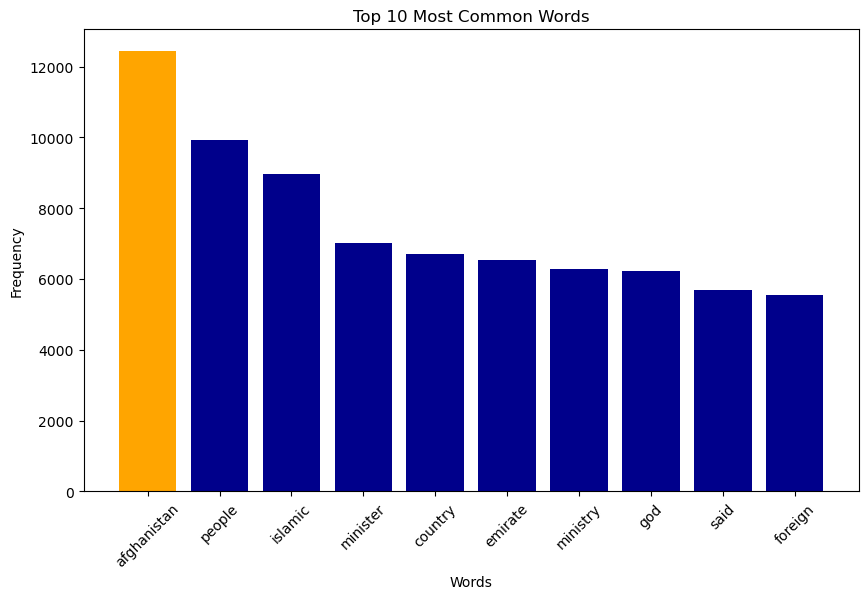

afghanistan: 12428
people: 9919
islamic: 8977
minister: 7009
country: 6704
emirate: 6531
ministry: 6290
god: 6231
said: 5695
foreign: 5563


In [42]:
import matplotlib.pyplot as plt
from collections import Counter

# Combine all the text into a single string
all_text = ' '.join(df['text'].tolist())

# Split the text into individual words
all_words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(all_words)

# Retrieve the most common words
most_common_words = word_counts.most_common(10)

# Extract the words and their frequencies
words = [word for word, count in most_common_words]
frequencies = [count for word, count in most_common_words]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar chart for the most common words
ax.bar(words, frequencies, color=['orange', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue'])

# Add labels and title
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 Most Common Words')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the chart
plt.show()


# Print the most common words and their frequencies
for word, count in most_common_words:
    print(f'{word}: {count}')


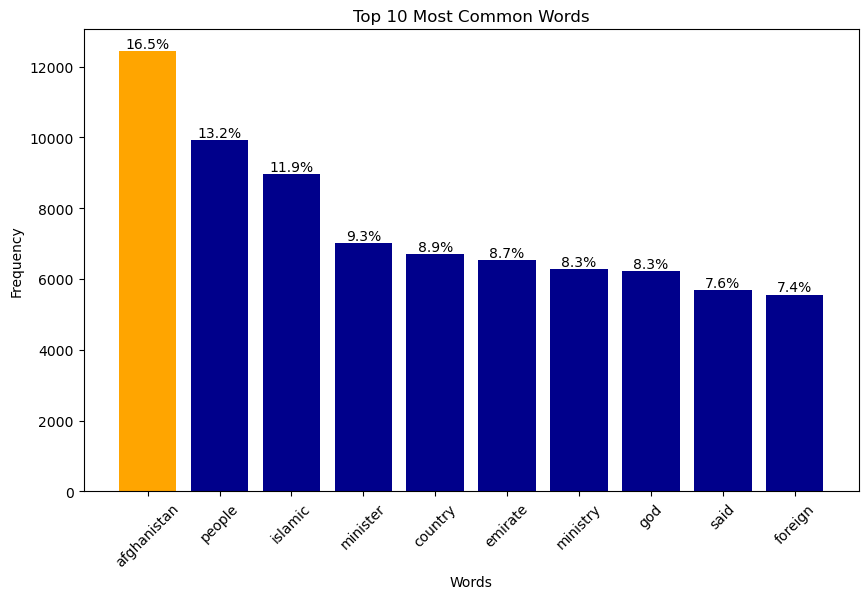

In [43]:
import matplotlib.pyplot as plt
from collections import Counter

# Combine all the text into a single string
all_text = ' '.join(df['text'].tolist())

# Split the text into individual words
all_words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(all_words)

# Retrieve the most common words
most_common_words = word_counts.most_common(10)

# Extract the words and their frequencies
words = [word for word, count in most_common_words]
frequencies = [count for word, count in most_common_words]

# Calculate the total frequency of all words
total_frequency = sum(frequencies)

# Calculate the percentages
percentages = [count / total_frequency * 100 for count in frequencies]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar chart for the most common words
bars = ax.bar(words, frequencies, color=['orange', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue'])

# Add labels and title
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 Most Common Words')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add percentage labels above each bar
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

# Show the chart
plt.show()


##### Calculate descriptive statistics for women


In [44]:
taliban_sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df[df['gender'] == 'male']['text']]
# Calculate descriptive statistics for women
taliban_mean_sentiment = np.mean(taliban_sentiment_scores)
taliban_median_sentiment = np.median(taliban_sentiment_scores)
taliban_std_sentiment = np.std(taliban_sentiment_scores)
taliban_quartiles_sentiment = np.percentile(taliban_sentiment_scores, [25, 50, 75])
print("Descriptive Statistics for Taliban:")
print("Mean Sentiment:", taliban_mean_sentiment)
print("Median Sentiment:", taliban_median_sentiment)
print("Standard Deviation of Sentiment:", taliban_std_sentiment)
print("Quartiles of Sentiment:", taliban_quartiles_sentiment)


Descriptive Statistics for Taliban:
Mean Sentiment: 0.07631385458823495
Median Sentiment: 0.0
Standard Deviation of Sentiment: 0.24179709502416724
Quartiles of Sentiment: [0.         0.         0.18333333]


##### Time Series

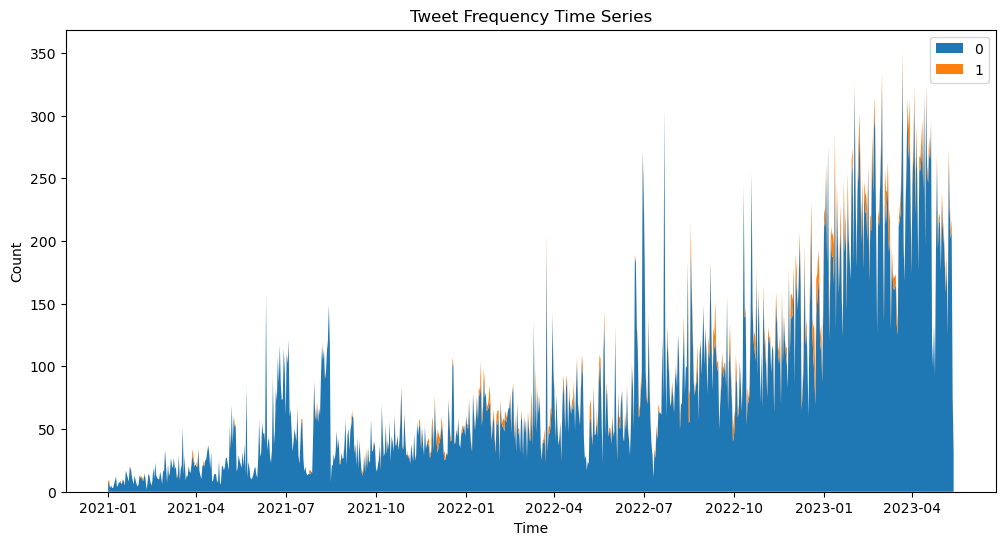

In [45]:

sentiment_counts = df.groupby(['created_at', 'label']).size().unstack()
# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(sentiment_counts.index)
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the stacked area plot for sentiment categories
ax.stackplot(time_periods, sentiment_counts.T, labels=sentiment_counts.columns)
# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Tweet Frequency Time Series')
# Add legend
ax.legend()
# Show the chart
plt.show()

##### Freqency Tweet

In [46]:
# Group the data by user name and count the number of tweets
user_tweet_counts = df.groupby('name').size().reset_index(name='tweet_count')

# Sort the user_tweet_counts DataFrame by tweet_count in descending order
user_tweet_counts = user_tweet_counts.sort_values(by='tweet_count', ascending=False)

# Print the top 10 users with the highest tweet counts
print(user_tweet_counts.head(10))


               name  tweet_count
44   mobeenkhan1231         4246
14  HabibiSamangani         3089
1      AWahidRayan1         2872
43  l8Kq2aPsS4XXQBh         2839
9          BdryMhsl         2791
21   MansourHaqqani         2633
24    MulaOmar_6926         2604
17  Hedayatullah111         2582
36    Zabehulah_M33         2563
32       TGhazniwal         2554


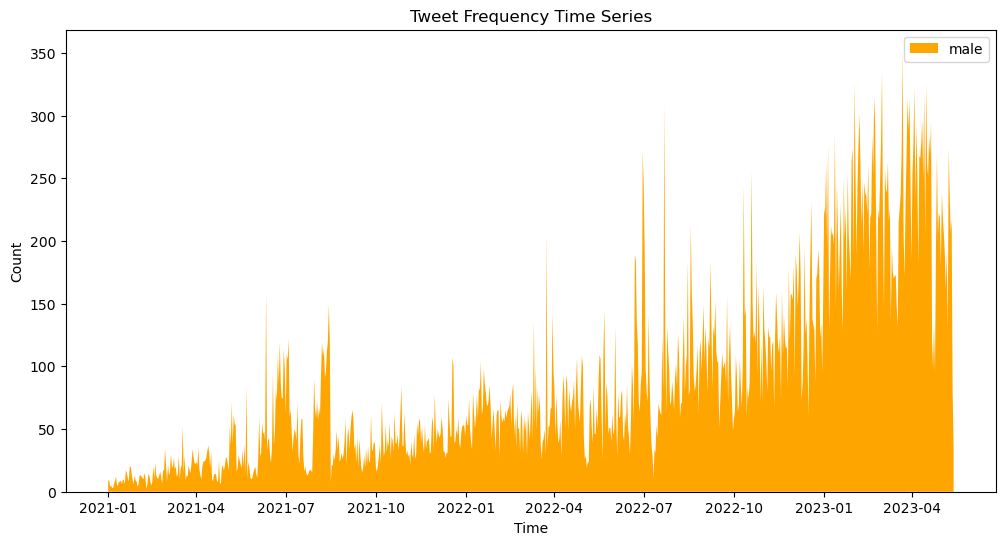

In [47]:
# Group the data by 'created_at' and 'gender', and count the number of tweets for each gender
freq_counts = df.groupby(['created_at', 'gender']).size().unstack()

# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(freq_counts.index)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the stacked area plot for genders
ax.stackplot(time_periods, freq_counts.T, labels=freq_counts.columns, colors=['orange', 'darkblue'])

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Tweet Frequency Time Series')

# Add legend
ax.legend()

# Show the chart
plt.show()


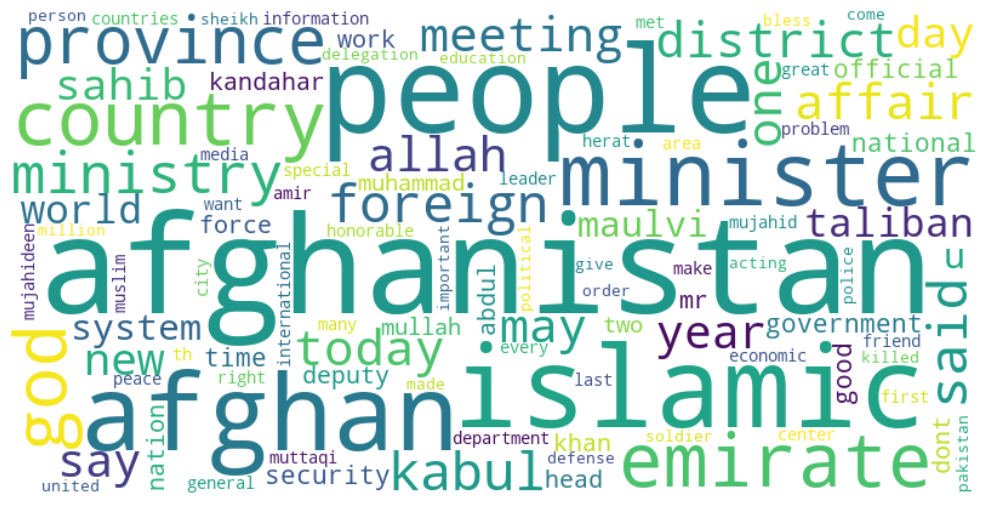

In [48]:
from wordcloud import WordCloud
text = ' '.join(df['text'])
# Create a WordCloud object with customized options
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
# Add a central word
wordcloud.generate_from_text("Afghanistan")
# Manipulate font sizes for the central word and other words
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
wordcloud.words_["Afghanistan"] = 80  # Set font size for the central word
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()


In [49]:
df.shape

(75970, 9)

In [50]:
keyword = 'education'
selected_data = df[df['text'].str.contains(keyword, case=False)]


selected_data.sample(5)

,text,name,created_at,gender,ethnic,label,sentiment,sentiment_score,codes_1
3356,year ad told amir almuminin adviser way possible provision education women within country among reasons one reason honor country sacrificed goals foreign enemies name education,abdulsalamzaeef,2022-03-24,male,pashtun,1,negative,-0.062500,"[women, education]"
40624,field citizens rights islamic emirate committed rights afghans islam ordered us give keep rights people also suitable educational environment provided women framework pure sharia islamic emirate pay special attention matter,MansourHaqqani,2021-07-18,male,pashtun,1,positive,0.342857,"[women, education]"
73348,gmicafghanistan higher education officials continuation governments accountability program nation held press conference government information media center,Zabehulah_M33,2022-08-17,male,pashtun,1,positive,0.075000,"[education, university]"
31712,congratulations faithful faithful suffering women afghanistan throughout history worlds muslims especially afghan women played effective role played significant role various conquests expansion education even success current year jihad happy islam,Hedayatullah111,2023-03-08,male,pashtun,1,positive,0.296429,"[women, education]"
1331,progress technical vocational education department says several young people built airplane together fly two kilometers,Shahidzai93,2023-02-06,male,pashtun,1,positive,0.240000,"[education, benefits]"


In [51]:
df.shape

(75970, 9)

In [52]:
# df.to_excel('../data_processed/taliban_tweets.xlsx', index=False)